In [0]:
#1.Create a Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col
#Creating a spark session
spark = SparkSession.builder.appName("CrimeData").getOrCreate()

In [0]:
#2. Define the schema for loading the Chicago crime dataset.
from pyspark.sql.types import *
crime_schema  = StructType([
  StructField("ID", IntegerType(), True),
  StructField("Case Number", StringType(), True),
  StructField("Date", StringType(), True),
  StructField("Block", StringType(), True),
  StructField("IUCR", StringType(), True),
  StructField("Primary Type", StringType(), True),
  StructField("Description", StringType(), True),
  StructField("Location Description", StringType(), True),
  StructField("Arrest", BooleanType(), True),
  StructField("Domestic", BooleanType(), True),
  StructField("Beat", IntegerType(), True),
  StructField("District", IntegerType(), True),
  StructField("Ward", IntegerType(), True),
  StructField("Community Area", IntegerType(), True),
  StructField("FBI Code", StringType(), True),
  StructField("X Coordinate", FloatType(), True),
  StructField("Y Coordinate", FloatType(), True),
  StructField("Year", IntegerType(), True),
  StructField("Updated On", StringType(), True),
  StructField("Latitude", FloatType(), True),
  StructField("Longitude", FloatType(), True),
  StructField("Location", StringType(), True)
])



In [0]:
#3.Load the Chicago crime data (you should get more than a million rows)
#Reference:https://medium.com/grabngoinfo/databricks-mount-to-aws-s3-and-import-data-4100621a63fd

In [0]:
# Define file type
file_type = "csv"
# Whether the file has a header
first_row_is_header = "true"
# Delimiter used in the file
delimiter = ","
# Read the CSV file to spark dataframe
aws_keys_df = spark.read.format(file_type).option("header", first_row_is_header).option("sep", delimiter).load("/FileStore/tables/VaishnaviKudikala_accessKeys.csv")

In [0]:
# pyspark functions
from pyspark.sql.functions import *
# URL processing
import urllib
# Get the AWS access key and secret key from the spark dataframe
ACCESS_KEY = aws_keys_df.select("Access key ID").collect()[0]["Access key ID"]
SECRET_KEY = aws_keys_df.select("Secret access key").collect()[0]["Secret access key"]
# Encode the secrete key
#ENCODED_SECRET_KEY1=SECRET_KEY.replace("/","%2F")
ENCODED_SECRET_KEY = urllib.parse.quote(string=SECRET_KEY, safe="")


In [0]:
AWS_S3_BUCKET = "data603"
MOUNT_NAME = "/mnt/chicagocrimedata"
SOURCE_URL = "s3n://{0}:{1}@{2}".format(ACCESS_KEY, ENCODED_SECRET_KEY, AWS_S3_BUCKET)
dbutils.fs.mount(SOURCE_URL, MOUNT_NAME)

Out[11]: True

In [0]:

crime_df_M = spark.read.csv("/mnt/chicagocrimedata/chicago_crime/Crimes_-_2001_to_Present.csv", header=True, schema=crime_schema)
crime_df_M.show()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 9

In [0]:
#to check number of nulls in each column
from pyspark.sql.functions import col,isnan, when, count
counts=crime_df_M.select([count(when(col(n).isNull(), n)).alias(n) for n in crime_df_M.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          4|   0|    0|   0|           0|          0|               10209|     0|       0|   0|      47|614848|        613476|       0|       85674|       85674|   0|         0|   85674|    85674|   85674|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

In [0]:
#4a. Remove all null values
#crime_df = crime_df.dropna()
#crime_df = crime_df.dropna("all")
crime_df_M=crime_df_M.na.drop(how="any")
crime_df_M.show()


+--------+-----------+--------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|   Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|

In [0]:
from pyspark.sql.functions import col,isnan, when, count
counts=crime_df_M.select([count(when(col(n).isNull(), n)).alias(n) for n in crime_df_M.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

In [0]:
crime_df_M.first()

Out[29]: Row(ID=10224738, Case Number='HY411648', Date='09/05/2015 01:30:00 PM', Block='043XX S WOOD ST', IUCR='0486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest=False, Domestic=True, Beat=924, District=9, Ward=12, Community Area=61, FBI Code='08B', X Coordinate=1165074.0, Y Coordinate=1875917.0, Year=2015, Updated On='02/10/2018 03:50:01 PM', Latitude=41.81511688232422, Longitude=-87.66999816894531, Location='(41.815117282, -87.669999562)')

In [0]:
#seperating the timestamp from Date column
crime_df_M1 = crime_df_M.withColumn('Date', split(crime_df_M.Date, ' ')[0])
crime_df_M1 = crime_df_M.withColumn('Time', split(crime_df_M.Date, ' ')[1])
crime_df_M1.show()

+--------+-----------+--------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|      ID|Case Number|                Date|               Block|IUCR|   Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|    Time|
+--------+-----------+--------------------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| fa

In [0]:
#4b. Change 'Date' column data type
crime_df = crime_df_M1.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy hh:mm:ss a").cast(DateType()))
crime_df.show()

+--------+-----------+----------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|      ID|Case Number|      Date|               Block|IUCR|   Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|    Time|
+--------+-----------+----------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|10224738|   HY411648|2015-09-05|     043XX S WOOD ST|0486|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|  12|        

In [0]:
#5. Filter the data for last ten years.
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from datetime import datetime, timedelta
current_date = datetime.now()
yrs_10 = current_date - timedelta(days=365*10)
crime_df = crime_df.filter(col("Date") >= yrs_10)
crime_df.show()

+--------+-----------+----------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|      ID|Case Number|      Date|               Block|IUCR|   Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On| Latitude| Longitude|            Location|    Time|
+--------+-----------+----------+--------------------+----+---------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+---------+----------+--------------------+--------+
|10224738|   HY411648|2015-09-05|     043XX S WOOD ST|0486|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|  12|        

In [0]:
# from pyspark.sql.functions import year
# crime_df1 = crime_df.filter((year("Date") >= 2014) & (year("Date") <= 2023))
# crime_df1.show()

In [0]:
#code to find the list of all primary crime types
data_types = crime_df.select("Primary Type").distinct().collect()
data_types

Out[37]: [Row(Primary Type='OFFENSE INVOLVING CHILDREN'),
 Row(Primary Type='CRIMINAL SEXUAL ASSAULT'),
 Row(Primary Type='STALKING'),
 Row(Primary Type='PUBLIC PEACE VIOLATION'),
 Row(Primary Type='OBSCENITY'),
 Row(Primary Type='NON-CRIMINAL (SUBJECT SPECIFIED)'),
 Row(Primary Type='ARSON'),
 Row(Primary Type='GAMBLING'),
 Row(Primary Type='CRIMINAL TRESPASS'),
 Row(Primary Type='ASSAULT'),
 Row(Primary Type='NON - CRIMINAL'),
 Row(Primary Type='LIQUOR LAW VIOLATION'),
 Row(Primary Type='MOTOR VEHICLE THEFT'),
 Row(Primary Type='THEFT'),
 Row(Primary Type='BATTERY'),
 Row(Primary Type='ROBBERY'),
 Row(Primary Type='HOMICIDE'),
 Row(Primary Type='PUBLIC INDECENCY'),
 Row(Primary Type='CRIM SEXUAL ASSAULT'),
 Row(Primary Type='HUMAN TRAFFICKING'),
 Row(Primary Type='INTIMIDATION'),
 Row(Primary Type='PROSTITUTION'),
 Row(Primary Type='DECEPTIVE PRACTICE'),
 Row(Primary Type='CONCEALED CARRY LICENSE VIOLATION'),
 Row(Primary Type='SEX OFFENSE'),
 Row(Primary Type='CRIMINAL DAMAGE'),
 Ro

In [0]:
#6. Remove all the records with the following crime types:
#'NON-CRIMINAL (SUBJECT SPECIFIED)'
#'OTHER OFFENSE'
#'STALKING'
#'NON - CRIMINAL'
#'ARSON'
crime_df=crime_df.where((crime_df["Primary Type"] != "NON-CRIMINAL (SUBJECT SPECIFIED)") & (crime_df["Primary Type"] != "OTHER OFFENSE") & (crime_df["Primary Type"] != "STALKING") & (crime_df["Primary Type"] != "NON-CRIMINAL") & (crime_df["Primary Type"] != "ARSON") & (crime_df["Primary Type"] != "NON - CRIMINAL"))



In [0]:
data_types = crime_df.select("Primary Type").distinct().collect()
data_types

Out[42]: [Row(Primary Type='OFFENSE INVOLVING CHILDREN'),
 Row(Primary Type='CRIMINAL SEXUAL ASSAULT'),
 Row(Primary Type='PUBLIC PEACE VIOLATION'),
 Row(Primary Type='OBSCENITY'),
 Row(Primary Type='GAMBLING'),
 Row(Primary Type='CRIMINAL TRESPASS'),
 Row(Primary Type='ASSAULT'),
 Row(Primary Type='LIQUOR LAW VIOLATION'),
 Row(Primary Type='MOTOR VEHICLE THEFT'),
 Row(Primary Type='THEFT'),
 Row(Primary Type='BATTERY'),
 Row(Primary Type='ROBBERY'),
 Row(Primary Type='HOMICIDE'),
 Row(Primary Type='PUBLIC INDECENCY'),
 Row(Primary Type='CRIM SEXUAL ASSAULT'),
 Row(Primary Type='HUMAN TRAFFICKING'),
 Row(Primary Type='INTIMIDATION'),
 Row(Primary Type='PROSTITUTION'),
 Row(Primary Type='DECEPTIVE PRACTICE'),
 Row(Primary Type='CONCEALED CARRY LICENSE VIOLATION'),
 Row(Primary Type='SEX OFFENSE'),
 Row(Primary Type='CRIMINAL DAMAGE'),
 Row(Primary Type='NARCOTICS'),
 Row(Primary Type='KIDNAPPING'),
 Row(Primary Type='BURGLARY'),
 Row(Primary Type='WEAPONS VIOLATION'),
 Row(Primary Type=

In [0]:
#7. Merge the similar crime types
crime_df = crime_df.withColumn("Primary Type", when((crime_df["Primary Type"] == "SEX OFFENSE") | (crime_df["Primary Type"] == "PROSTITUTION") | ((crime_df["Primary Type"] == "CRIM SEXUAL ASSAULT") | ((crime_df["Primary Type"] == "CRIMINAL SEXUAL ASSAULT"))), "SEX OFFENSE").otherwise(crime_df["Primary Type"]))
crime_df= crime_df.withColumn("Primary Type", when((crime_df["Primary Type"] == "HUMAN TRAFFICKING") | (crime_df["Primary Type"] == "KIDNAPPING"), "HUMAN TRAFFICKING").otherwise(crime_df["Primary Type"]))
crime_df = crime_df.withColumn("Primary Type", when((crime_df["Primary Type"] == "THEFT") | (crime_df["Primary Type"] == "MOTOR VEHICLE THEFT") |  (crime_df["Primary Type"] == "ROBBERY") | (crime_df["Primary Type"] == "BURGLARY"), "THEFT").otherwise(crime_df["Primary Type"]))
crime_df= crime_df.withColumn("Primary Type", when((crime_df["Primary Type"] == "NARCOTICS") | (crime_df["Primary Type"] == "OTHER NARCOTIC VIOLATION"), "NARCOTICS").otherwise(crime_df["Primary Type"]))
crime_df = crime_df.withColumn("Primary Type", when((crime_df["Primary Type"] == "PUBLIC PEACE VIOLATION") | (crime_df["Primary Type"] == "CRIMINAL TRESPASS") | (crime_df["Primary Type"] == "ASSAULT") | (crime_df["Primary Type"] == "PUBLIC INDECENCY") |  (crime_df["Primary Type"] == "INTIMIDATION"), "PUBLIC PEACE VIOLATION").otherwise(crime_df["Primary Type"]))


In [0]:
data_types = crime_df.select("Primary Type").distinct().collect()
data_types

Out[44]: [Row(Primary Type='OFFENSE INVOLVING CHILDREN'),
 Row(Primary Type='PUBLIC PEACE VIOLATION'),
 Row(Primary Type='OBSCENITY'),
 Row(Primary Type='GAMBLING'),
 Row(Primary Type='LIQUOR LAW VIOLATION'),
 Row(Primary Type='THEFT'),
 Row(Primary Type='BATTERY'),
 Row(Primary Type='HOMICIDE'),
 Row(Primary Type='HUMAN TRAFFICKING'),
 Row(Primary Type='DECEPTIVE PRACTICE'),
 Row(Primary Type='CONCEALED CARRY LICENSE VIOLATION'),
 Row(Primary Type='SEX OFFENSE'),
 Row(Primary Type='CRIMINAL DAMAGE'),
 Row(Primary Type='NARCOTICS'),
 Row(Primary Type='WEAPONS VIOLATION'),
 Row(Primary Type='INTERFERENCE WITH PUBLIC OFFICER'),
 Row(Primary Type='RITUALISM')]

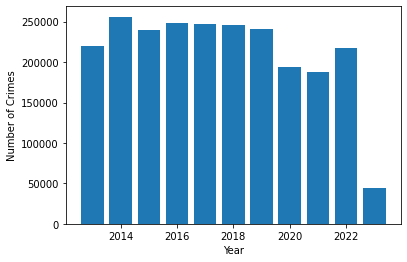

In [0]:
#Show year-wise trend of the crime for last ten years
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
import pandas as pd
crime_df= crime_df.withColumn("Year", year(crime_df["Date"]))
col_year = crime_df.groupBy("Year").count().orderBy("Year")
# converting the data into pandas dataframe to visualize it
col_year_pd = col_year.toPandas()
plt.bar(col_year_pd["Year"],col_year_pd["count"])
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

In [0]:
#Find out at which hour of the day crime is highest
from pyspark.sql.functions import hour
crime_df = crime_df.withColumn("Hour", hour(crime_df["Time"]))
Col_hour= crime_df.groupBy("Hour").count().orderBy("count", ascending=False)
highest_hour_of_day= Col_hour.first()["Hour"]

print("The hour with the highest numer of crimes is ", highest_hour_of_day)

The hour with the highest numer of crimes is  12


In [0]:
#Find top ten crimes and present them as a bar chart
primary_counts = crime_df.groupBy("Primary Type").agg(count("*").alias("count")).orderBy("count", ascending=False)
top10 = primary_counts.limit(10)
top10.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|895269|
|             BATTERY|469037|
|     CRIMINAL DAMAGE|276210|
|PUBLIC PEACE VIOL...|267231|
|  DECEPTIVE PRACTICE|155303|
|           NARCOTICS|144409|
|   WEAPONS VIOLATION| 56554|
|         SEX OFFENSE| 31793|
|OFFENSE INVOLVING...| 20825|
|INTERFERENCE WITH...| 10008|
+--------------------+------+



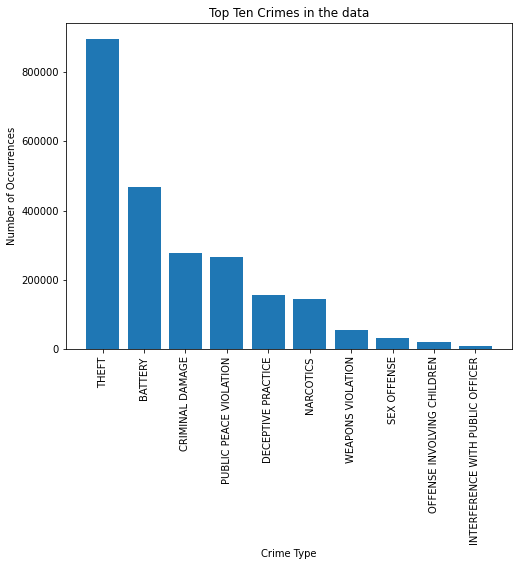

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
top10_pd = top10.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(top10_pd["Primary Type"], top10_pd["count"])
plt.xticks(rotation=90)
plt.xlabel("Crime Type")
plt.ylabel("Number of Occurrences")
plt.title("Top Ten Crimes in the data")
plt.show()